### Intern take-home Assessment:

In [1]:
import os
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn import metrics
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns
from tableone import TableOne

* The question is:
"predict what profits MIGHT have been at each of the three candidate locations IF 
the locations had been open and operating during appropriate time periods 
from January 1st through October 30th of 2022. 
Based on these predictions, which location would have likely been the most profitable 
in the first 10 months of 2022 if it had been open for business?

### Data preprocessing:

In [2]:
#import all dataset with different format:
directory = "data"
original_transaction_data = []
original_characteristics_data = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        data_type = f.split('.')[0].split('_')[0].split('/')[1] #i.e. transactions, weather, holiday, location
        if data_type == 'transactions' and f.split('.')[-1] == 'txt': # read in the txt type file
            dta = pd.read_csv(f, sep = "\t")
            original_transaction_data.append(dta)
        elif data_type == 'transactions' and f.split('.')[-1] == 'json': # read in the json type file
            dta = pd.read_json(f)
            original_transaction_data.append(dta)
        elif data_type == 'transactions' and f.split('.')[-1] == 'csv': # read in the csv type file
            dta = pd.read_csv(f)
            original_transaction_data.append(dta)
        else:
            dta = pd.read_csv(f)
            original_characteristics_data.append(dta)

In [3]:
#concatenate all of the transaction data together
transaction_data = pd.concat(original_transaction_data)

In [4]:
# Data moderation for characteristics of the data
data_weather = original_characteristics_data[0]
data_holiday = original_characteristics_data[1]
data_location = original_characteristics_data[2]
data_weather['day_of_year'] = pd.to_datetime(data_weather['date']).dt.dayofyear #convert out the the number days of the year as a new variable
data_weather['week_of_year'] = pd.to_datetime(data_weather['date']).dt.isocalendar().week # the number of weeks of the year as new variable
data_weather['week_of_year'] = data_weather['week_of_year'].astype(int) # convert type to be integer
data_weather['month_of_year'] = pd.to_datetime(data_weather['date']).dt.month # the number of months of the year as new variable
data_weather['weekdays'] = pd.to_datetime(data_weather['date']).dt.dayofweek # the weekdays of the date, i.e., 1 == Monday
data_weather['year'] = pd.to_datetime(data_weather['date']).dt.year # year of the date
data_weather['snow'] = np.where(data_weather['temperature'] < 32, 1, 0) #1 means snow, 0 means river
#if the temperature is lower than 32F then it will be snow type

In [5]:
#unify the format of the profit data using regular expression.
profit = []
for i in transaction_data.profit:#.str[2:]:
    #print(i)
    #print(type(str(i)))
    res = re.sub('[-$]', '', str(i))
    profit.append(float(str(res)))
transaction_data['profit'] = profit

##### Concatenate all other variables except transactions:

In [6]:
# unify and formalize the date variable
data_weather['date'] = pd.to_datetime(data_weather['date']).dt.strftime('%m-%d-%Y') #location data
data_holiday['date'] = pd.to_datetime(data_holiday['date']).dt.strftime('%m-%d-%Y') #holiday data

In [7]:
#firstly, combine the holiday with the location data:
characteristics_data = data_weather.merge(data_holiday, how = 'left', on = 'date')
characteristics_data = characteristics_data.fillna(0) #fill out the holiday indicator to be 0 for missing values in holiday
characteristics_data.holiday = characteristics_data.holiday.astype(int)

In [8]:
#secondly, combine the merged data with location data (i.e., population, elevation)
characteristics_data = characteristics_data.merge(data_location, how = 'left', on = 'location_id')

In [9]:
#thirdly, aggregate the profits for each location for each day:
agg_transaction_data = (transaction_data
    .groupby(['location_id', 'date'])
    ['profit'].sum()
    .reset_index(level=[0,1]))
agg_transaction_data['date'] = pd.to_datetime(agg_transaction_data.date).dt.strftime('%m-%d-%Y')

In [10]:
#change the format to make sure that the transaction data and other information are using the same date format
characteristics_data['date'] = pd.to_datetime(characteristics_data.date).dt.strftime('%Y-%m-%d')
agg_transaction_data['date'] = pd.to_datetime(agg_transaction_data.date).dt.strftime('%Y-%m-%d')

In [11]:
#merge the aggregated transaction data with the other characteristics of the different location
final_data = agg_transaction_data.merge(characteristics_data, on = ['location_id', 'date'], how = 'left')
#use last observation carry forward for the missing data:
final_data = final_data.sort_values(['location_id', 'date'], ascending = [True, True])
final_data = final_data.ffill(axis = 0) # Last Observation Carried Forward (LOCF) for some charateristics that are missing

In [12]:
#drop holiday because they are all non holidays:
characteristics_data = characteristics_data.drop(['holiday'], axis = 1)
final_data = final_data.drop(['holiday'], axis = 1)

In [13]:
final_data.shape #check the shape of the data

(7642, 16)

### Exploratory data analysis

##### Correlation plot

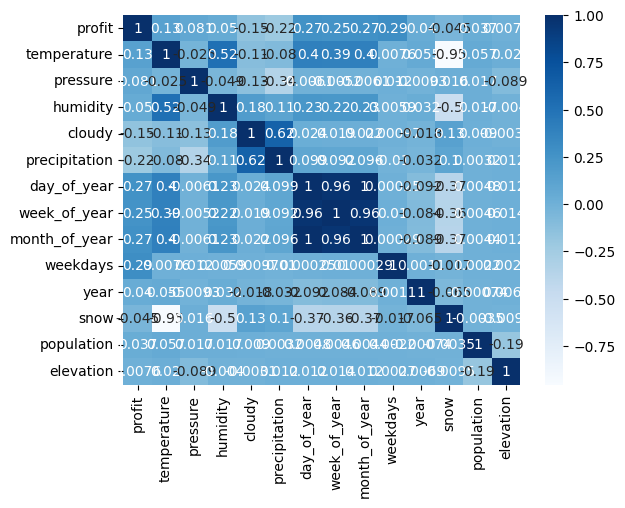

In [14]:
#Firstly, we can draw the correlation plot
corr = final_data.iloc[:, 2:].corr()
sns.heatmap(corr, cbar = True,annot = True,cmap = 'Blues')
plt.show()

* We can see that the most correlated variable to profit would be time variables. Temperature and precipitation is also correlated with the profits.

##### Time Series Plot

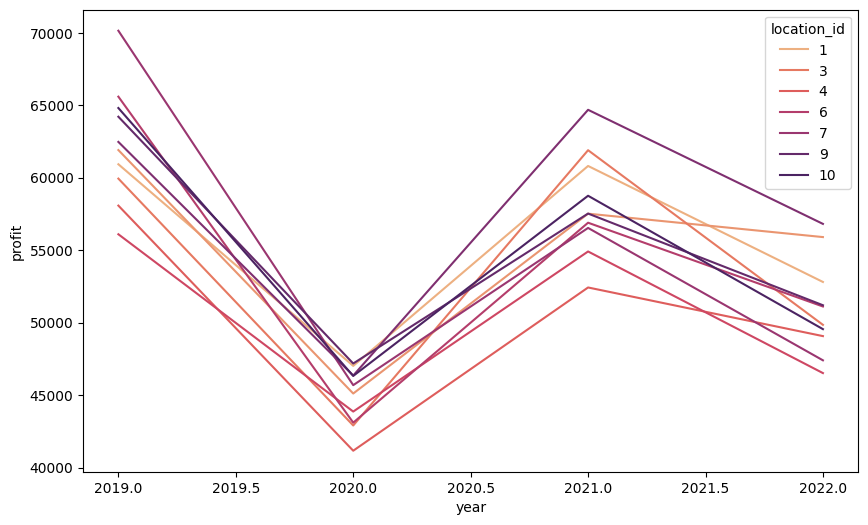

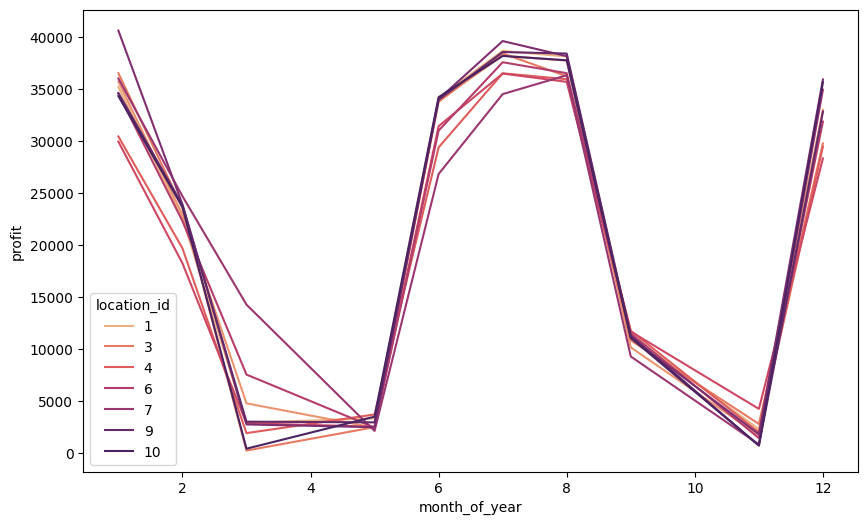

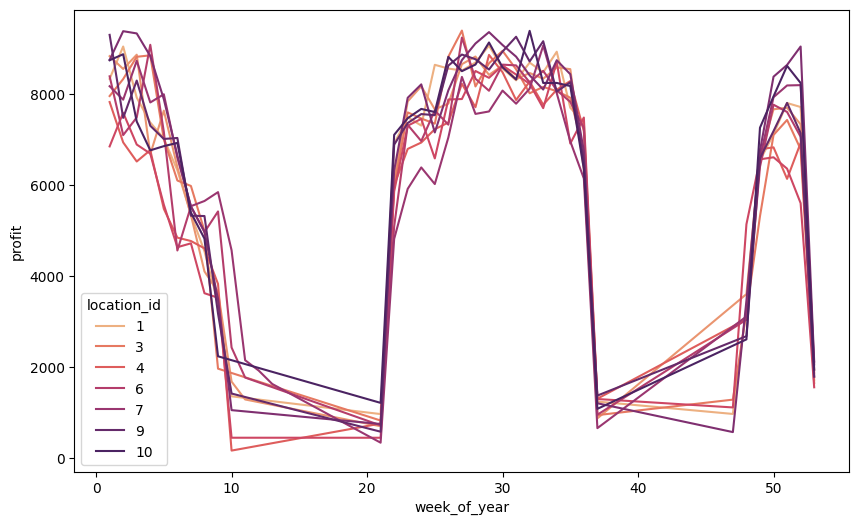

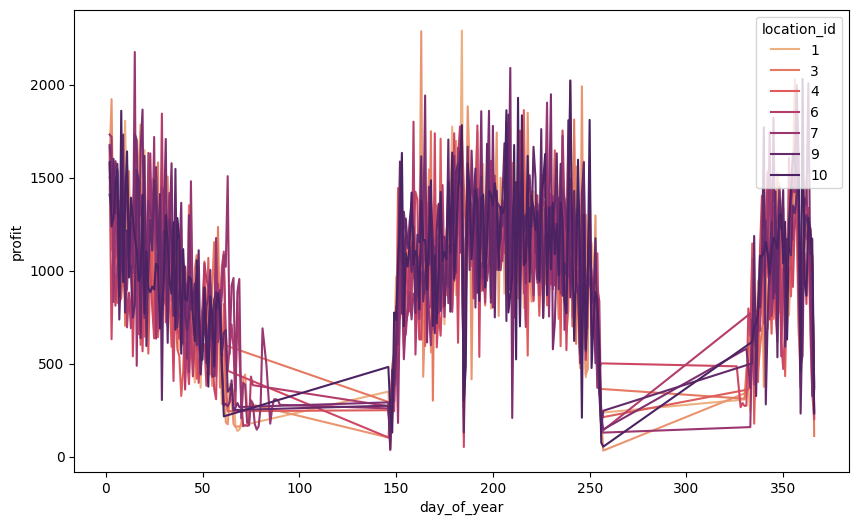

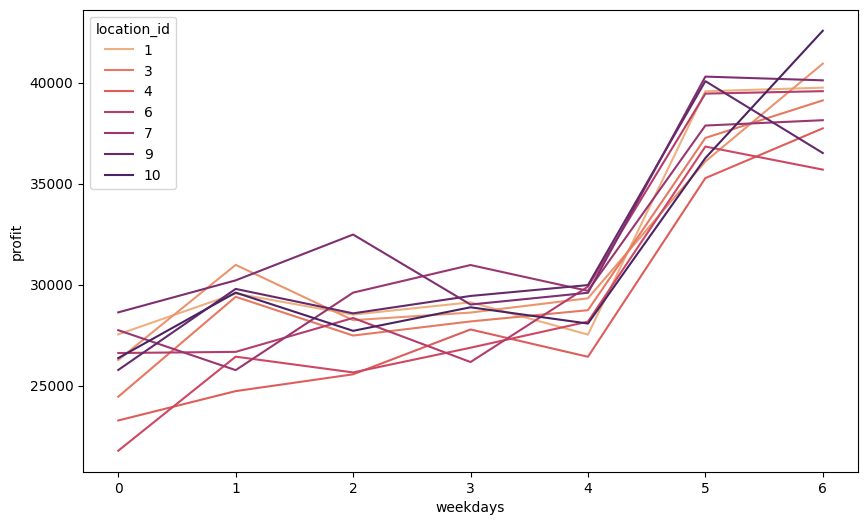

In [15]:
#Profit plot over time variables:
plt.figure(figsize = (10,6))
sns.lineplot(data = final_data.groupby(['location_id', 'year'])['profit'].sum().reset_index(), x='year', y='profit', hue='location_id',palette = "flare")

plt.figure(figsize = (10,6))
sns.lineplot(data = final_data.groupby(['location_id', 'month_of_year'])['profit'].sum().reset_index(), x='month_of_year', y='profit', hue='location_id', palette = "flare")

plt.figure(figsize = (10,6))
sns.lineplot(data = final_data.groupby(['location_id', 'week_of_year'])['profit'].sum().reset_index(), x='week_of_year', y='profit', hue='location_id', palette = "flare")

plt.figure(figsize = (10,6))
sns.lineplot(data = final_data.groupby(['location_id', 'day_of_year'])['profit'].sum().reset_index(), x='day_of_year', y='profit', hue='location_id', palette = "flare")

plt.figure(figsize = (10,6))
sns.lineplot(data = final_data.groupby(['location_id', 'weekdays'])['profit'].sum().reset_index(), x='weekdays', y='profit', hue='location_id', palette = "flare")
plt.show()


* Obviously profit is good in the winter time and summer time. 
* Weekends always have larger profits. 
* From the plots above, we might want to add new indicators to indicate the off-season time in year, months, weeks, weekdays or weekends to predict the profits more accurately:

##### Adding some new variables for the data

In [16]:
#from the exploratory analysis: we might want to add the off-season indicator to indicate whethether this is the profit 
#for off-season time period:
final_data['off_season_in_year'] = np.where(final_data['year'] == 2020, 1, 0) #profit affected by the pandemic
final_data['off_season_in_week'] = np.where(final_data['week_of_year'].isin(list(range(10, 21))), 1, 0)
final_data['off_season_in_month'] = np.where(final_data['month_of_year'].isin(list(range(3, 6))), 1, 0)
final_data['off_season_in_days'] = np.where(final_data['month_of_year'].isin(list(range(60, 140))), 1, 0)

In [17]:
#add the new columns to characterisitcs_data also, so that location 11, 12, 13 will also have the new columns for the future predictions
characteristics_data['off_season_in_year'] = np.where(characteristics_data['year'] == 2020, 1, 0) #profit affected by the pandemic
characteristics_data['off_season_in_week'] = np.where(characteristics_data['week_of_year'].isin(list(range(10, 21))), 1, 0)
characteristics_data['off_season_in_month'] = np.where(characteristics_data['month_of_year'].isin(list(range(3, 6))), 1, 0)
characteristics_data['off_season_in_days'] = np.where(characteristics_data['month_of_year'].isin(list(range(60, 140))), 1, 0)

##### Boxplot for some categorical variable

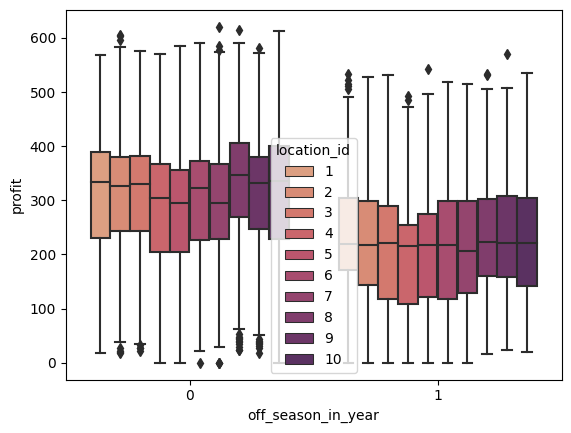

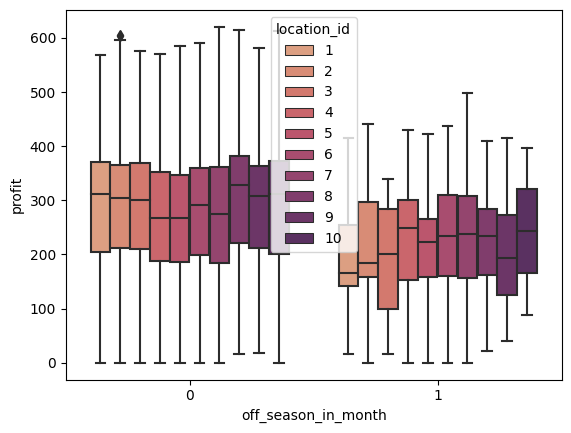

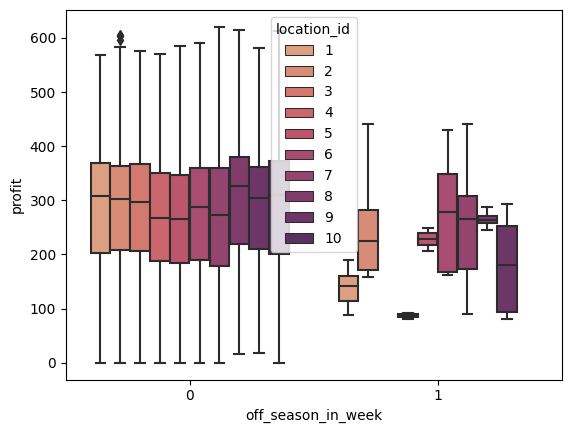

In [18]:
# Box plot for profit vs off-season indicator in different units
sns.boxplot(data= final_data, x='off_season_in_year', y='profit', hue='location_id', palette = "flare")
plt.show()
sns.boxplot(data= final_data, x='off_season_in_month', y='profit', hue='location_id', palette = "flare")
plt.show()
sns.boxplot(data= final_data, x='off_season_in_week', y='profit', hue='location_id', palette = "flare")
plt.show()

* off-season indicators shows very obvious differences where non off-seaons time period has larger profits

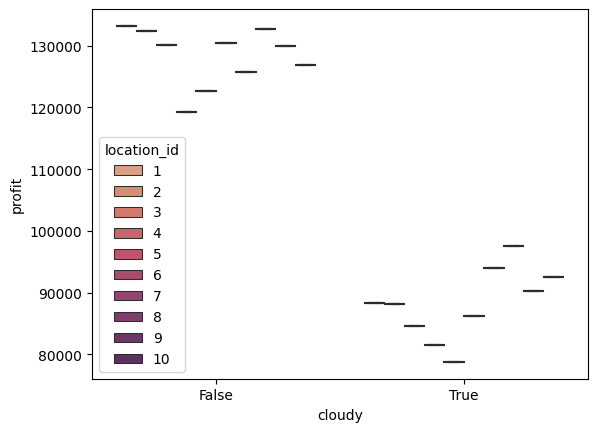

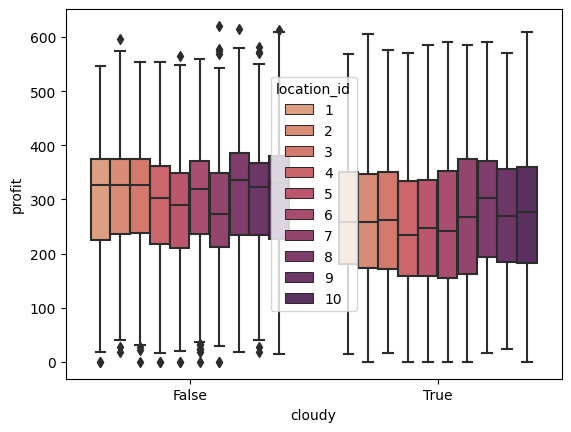

In [19]:
# Cloudy day profit:
sns.boxplot(data= final_data.groupby(['location_id', 'cloudy'])['profit'].sum().reset_index(), x='cloudy', y='profit', hue='location_id', palette = "flare")
plt.show()
sns.boxplot(data= final_data, x='cloudy', y='profit', hue='location_id', palette = "flare")
plt.show()

* First plot is the aggregated profits for the cloudy and non cloudy days. Obviously the non-cloudy days have larger profits.
* Second plot is the non aggregated profits based on the cloudy condition. We also can observe that the non-cloudy day has larger profits

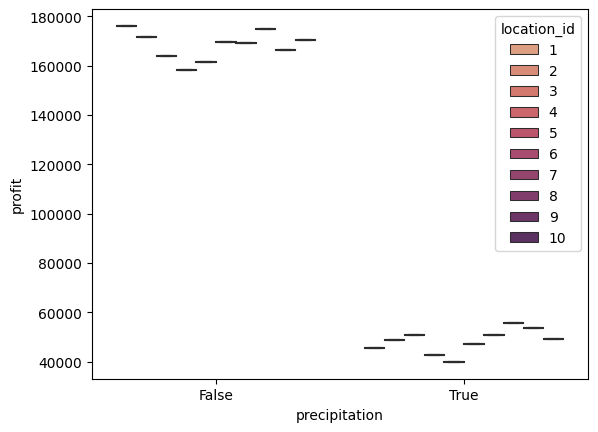

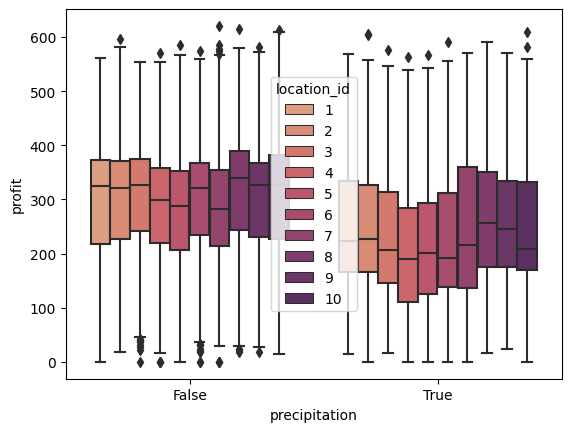

In [20]:
# Precipitation profit:
sns.boxplot(data= final_data.groupby(['location_id', 'precipitation'])['profit'].sum().reset_index(), x='precipitation', y='profit', hue='location_id', palette = "flare")
plt.show()
sns.boxplot(data= final_data, x='precipitation', y='profit', hue='location_id', palette = "flare")
plt.show()

* Similar to cloudy condition where non-rainy day has larger profits for each location

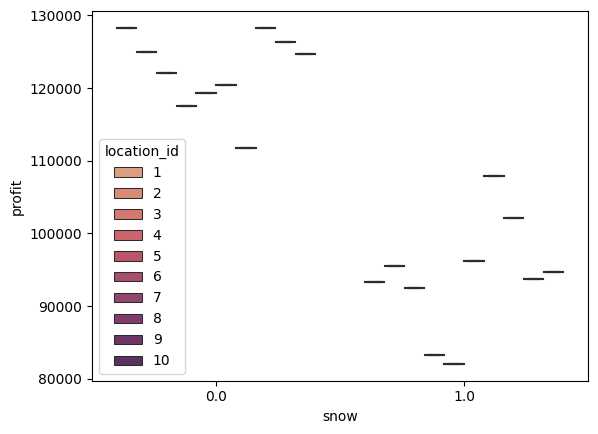

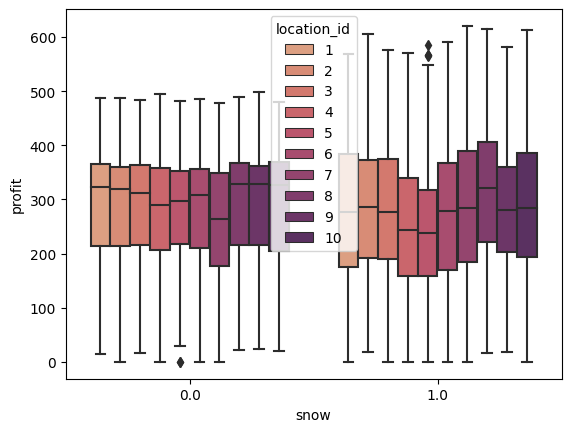

In [21]:
# Snow/River vs profit:
sns.boxplot(data= final_data.groupby(['location_id', 'snow'])['profit'].sum().reset_index(), x='snow', y='profit', hue='location_id', palette = "flare")
plt.show()
sns.boxplot(data= final_data, x='snow', y='profit', hue='location_id', palette = "flare")
plt.show()

* aggregated snow/river shows that river has larger profits, and the box plot also shows it too

##### Aggregated plot for some variables

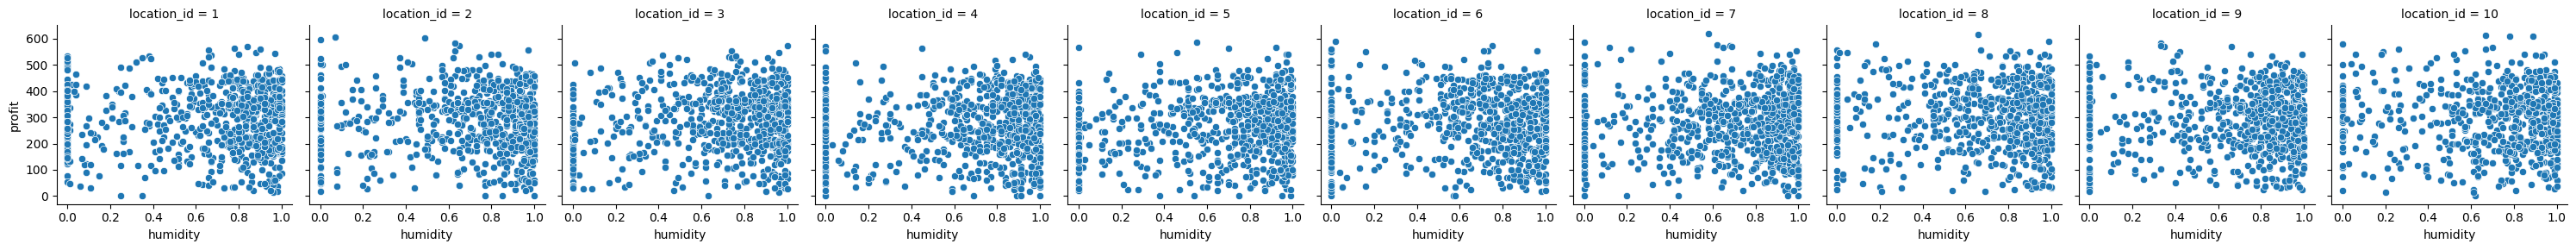

In [22]:
# Humidity vs profits:
g = sns.FacetGrid(final_data, col="location_id")
g.map_dataframe(sns.scatterplot, x = 'humidity', y = "profit")
plt.show()

* Did not observe obvious linear relationship between humidity vs profit

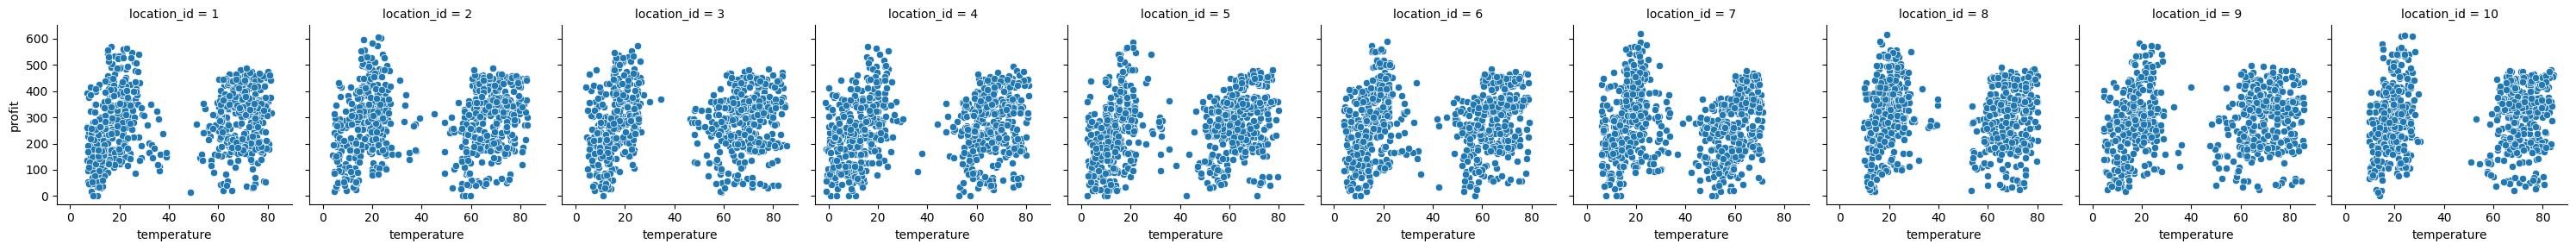

In [23]:
# Temperature vs profits
g = sns.FacetGrid(final_data, col="location_id")
g.map_dataframe(sns.scatterplot, x = 'temperature', y = "profit")
plt.show()

* Here we can see that the temperature around 30 F can give us the largest profit, and there is obvious linear relationship between temperature and profit.

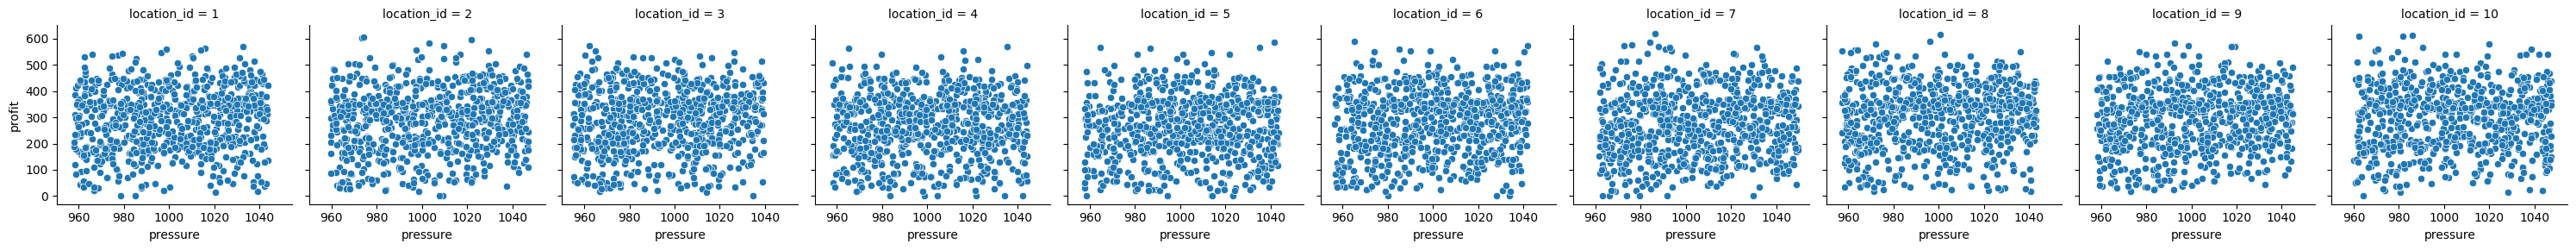

In [24]:
# Pressure vs profit
g = sns.FacetGrid(final_data, col="location_id")
g.map_dataframe(sns.scatterplot, x = 'pressure', y = "profit")
plt.show()

* No obvious lineary relationship between pressure and profits

##### Other plots

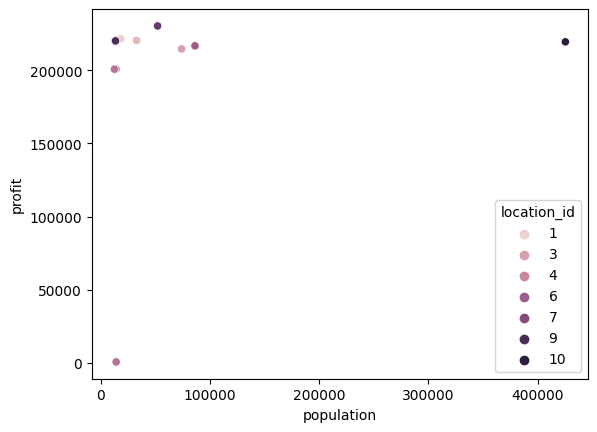

In [25]:
# Population vs profit
sns.scatterplot(data = final_data.groupby(['location_id', 'population']).agg({'profit': np.sum}).reset_index(), x = 'population', y = 'profit', hue = 'location_id')
plt.show()

* We thought that larger population means larger profits. But it didn't show us such trend where one location with more than 400000 population has simlar profits with other locations

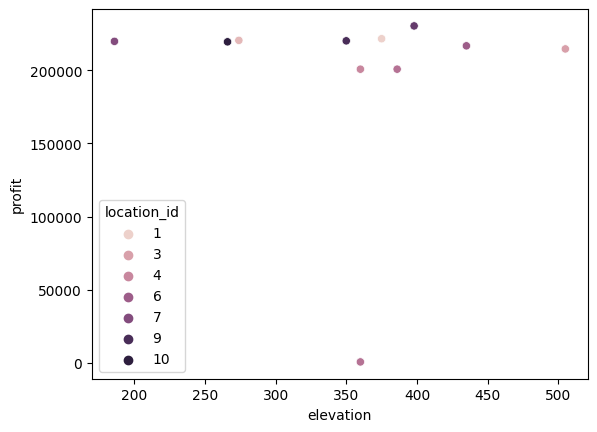

In [26]:
#Elevation vs profit
sns.scatterplot(data = final_data.groupby(['location_id', 'elevation']).agg({'profit': np.sum}).reset_index(), x = 'elevation', y = 'profit', hue = 'location_id')
plt.show()

* Non obvious linear relationship between elevation vs profit.

##### Creat a TableOne for the data to quickly check the data entry values

In [27]:
groupby = ['location_id']
categorical = ['cloudy', 'precipitation', 'snow']
columns = ['location_id', 'profit', 'temperature', 'pressure', 'humidity',
       'cloudy', 'precipitation', 'snow']
TableOne(final_data, columns = columns, categorical = categorical, groupby = groupby, pval = True)

Grouped by location_id                                                                                                                                                                             
                                            Missing        Overall              1             10              2              3              4              5              6              7              8              9 P-Value
n                                                             7642            767            746            766            748            755            766            776            802            757            759        
profit, mean (SD)                                 0  283.3 (118.4)  288.9 (116.5)  294.2 (118.6)  287.8 (118.1)  286.9 (117.4)  265.9 (118.4)  262.9 (116.0)  279.3 (118.4)  274.0 (121.1)  304.3 (118.7)  290.0 (115.5)  <0.001
temperature, mean (SD)                            0    44.1 (26.2)    45.9 (26.6)    48.5 (26.8)    44.9 (26.2)    45.4 (27.2)    42.0 (28.2)    41.0 (25.9)    41.7 (25.3)    39.2 (21.9)    46.7 (25.1)    46.2 (27.3)  <0.001
pressure, mean (SD)                               0  1001.4 (25.1)  1001.2 (24.6)  1003.7 (25.8)  1003.1 (25.4)   996.0 (24.4)  1000.9 (24.9)  1002.8 (24.3)  1000.2 (24.2)  1005.2 (25.9)   999.6 (25.2)  1000.7 (25.4)  <0.001
humidity, mean (SD)                               0      0.7 (0.3)      0.7 (0.3)      0.7 (0.3)      0.7 (0.3)      0.7 (0.3)      0.7 (0.3)      0.7 (0.3)      0.7 (0.3)      0.7 (0.3)      0.7 (0.3)      0.7 (0.3)   0.225
cloudy, n (%)          False                      0    4284 (56.1)     439 (57.2)     409 (54.8)     427 (55.7)     422 (56.4)     414 (54.8)     443 (57.8)     431 (55.5)     453 (56.5)     422 (55.7)     424 (55.9)   0.979
                       True                            3358 (43.9)     328 (42.8)     337 (45.2)     339 (44.3)     326 (43.6)     341 (45.2)     323 (42.2)     345 (44.5)     349 (43.5)     335 (44.3)     335 (44.1)        
precipitation, n (%)   False                      0    5623 (73.6)     587 (76.5)     550 (73.7)     564 (73.6)     531 (71.0)     552 (73.1)     583 (76.1)     567 (73.1)     596 (74.3)     548 (72.4)     545 (71.8)   0.294
                       True                            2019 (26.4)     180 (23.5)     196 (26.3)     202 (26.4)     217 (29.0)     203 (26.9)     183 (23.9)     209 (26.9)     206 (25.7)     209 (27.6)     214 (28.2)        
snow, n (%)            0.0                        0    4247 (55.6)     432 (56.3)     418 (56.0)     428 (55.9)     419 (56.0)     420 (55.6)     426 (55.6)     426 (54.9)     427 (53.2)     428 (56.5)     423 (55.7)   0.980
                       1.0                             3395 (44.4)     335 (43.7)     328 (44.0)     338 (44.1)     329 (44.0)     335 (44.4)     340 (44.4)     350 (45.1)     375 (46.8)     329 (43.5)     336 (44.3)

### Modeling

* I found that the business might be closed for certain dates, and there are no transactions at all for those dates
* So we might want to build up a model to predict whether the business might be off-season(close) or not

In [28]:
# First model for possible off_season date using 1-10 locations:
### Left join the characteristics data with transaction data to define the off-season based on transactions
off_season_data = characteristics_data[characteristics_data.location_id.isin(list(range(1, 11)))].merge(agg_transaction_data, on=['location_id', 'date'], how = 'left')
off_season_data = off_season_data.rename(columns = {'profit': 'off_season'}) # Change the profit column name to be off-season indicator
off_season_data['off_season'] = np.where(off_season_data['off_season'].isna(), 1, 0) # Define the off-season indicator if transaction is missing value

In [30]:
# classification model for predicting whether business operates or not:
#define X and y data:
X = np.array(off_season_data.iloc[:, off_season_data.columns.get_loc('temperature'):off_season_data.columns.get_loc('off_season')])
y = np.array(off_season_data.loc[:, 'off_season'])

# Train test split for the data
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler()
scalerX = StandardScaler().fit(X_train) #only use training data for generating the scaling function
X_train = scalerX.transform(X_train) #transform the orginal data to scaled data
X_test = scalerX.transform(X_test) 

# Predict the off-season indicator:
model = RandomForestClassifier(random_state = 0).fit(X_train, y_train)
y_pred = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(metrics.auc(fpr, tpr)) # print out the AUC

0.9864525727172818


In [31]:
# Selecting out the data for the new locations: 11, 12, 13
off_season_data_new = characteristics_data[characteristics_data.location_id.isin(list(range(11, 14)))]
X_new = scalerX.transform(np.array(off_season_data_new.iloc[:, 2:])) # Scale transform the new location data

# Used this new data with the new off_season column to indicate th business operation
off_season_data = off_season_data.assign(off_season_pred = model.predict(scalerX.transform(X))) #predict on the old location data for off-season prediction
new_location_data = off_season_data_new.assign(off_season = model.predict(X_new)) # predict on the new location data for off-season prediction

In [32]:
# Check the model accuracy on the training data
metrics.accuracy_score(off_season_data.off_season, off_season_data.off_season_pred)

0.9966122110968908

In [33]:
# Check the number of off_season days with transactions
profit_data_with_off_season = final_data.merge(off_season_data[['location_id', 'date', 'off_season_pred']], on = ['location_id', 'date'], how = 'left')

In [34]:
np.sum(profit_data_with_off_season.off_season_pred)

25.0

* Not necessary to model off season trasaction data for off season profit prediction because there are only 22 data points

#### Modeling for profits

In [35]:
#define X and y data from final_data:
X = np.array(final_data.iloc[:, 3:])
y = np.array(final_data.iloc[:, 2])

In [36]:
scaler = StandardScaler() #z-score standardizing for the data
#split the data to training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y)

scalerX = StandardScaler().fit(X_train) #only use training data for generating the scaling function
X_train = scalerX.transform(X_train) #transform the orginal data to scaled data
X_test = scalerX.transform(X_test) #standardize the testing data using the scaler created by training data

In [37]:
#Save the prediction result for each method:
model_names = []
fitted_model = []
MSEs = []
R2 = []

# Aggregate each model together to check performance
models = {'Linear Regression' : LinearRegression(),
          'Lasso': LassoCV(cv = 5, random_state = 1, max_iter = 100000),
          'Elastic Net': ElasticNetCV(cv = 5, random_state = 1, max_iter = 100000),
          'Random Forest': RandomForestRegressor(random_state=0),
          'Gradient Boosting': GradientBoostingRegressor(random_state=0)}

# Train each model and get MSE to check performance
for model_name, model in models.items():
    print(model_name)
    regressor = model.fit(X_train, y_train)
    fitted_model.append(regressor)
    y_pred = model.predict(X_test)
    print('MSE', mean_squared_error(y_test, y_pred))
    print('R2_score', r2_score(y_test, y_pred))
    model_names.append(model_name)
    MSEs.append(mean_squared_error(y_test, y_pred))
    R2.append(r2_score(y_test, y_pred))

Linear Regression
MSE 8564.013187766708
R2_score 0.4039292382277323
Lasso
MSE 8570.98559558092
R2_score 0.4034439460701793
Elastic Net
MSE 8849.615449124156
R2_score 0.3840508057967319
Random Forest
MSE 3168.5985368318607
R2_score 0.7794598277478376
Gradient Boosting
MSE 3039.5145511650767
R2_score 0.7884443059337085


In [38]:
pd.DataFrame({'Model Name': model_names, 'MSE': MSEs, 'R2 Score': R2}) # Show the result in dataframe

,Model Name,MSE,R2 Score
0,Linear Regression,8564.013188,0.403929
1,Lasso,8570.985596,0.403444
2,Elastic Net,8849.615449,0.384051
3,Random Forest,3168.598537,0.779460
4,Gradient Boosting,3039.514551,0.788444


* Here we can see the best peformance model is the GradientBoosting

##### Make prediction

In [39]:
#retrieve the data to be predicted from location 11, 12, 13:

In [40]:
X_new = scalerX.transform(np.array(new_location_data.iloc[:, 2:-1]))

In [41]:
#predict the profit based on 4 models:
for model_name in model_names:
    y_pred = fitted_model[model_names.index(model_name)].predict(X_new)
    new_location_data.insert(2, 'profit_pred ' + model_name, y_pred)

* Mask the profit using the predicted off_season date:

In [42]:
# Change the profits to be 0 with off_season indicator
for pred_profit in ['profit_pred Gradient Boosting', 'profit_pred Random Forest', 'profit_pred Elastic Net', 'profit_pred Lasso', 'profit_pred Linear Regression']:
    new_location_data[pred_profit] = np.where(new_location_data.off_season == 1, 0, new_location_data[pred_profit])

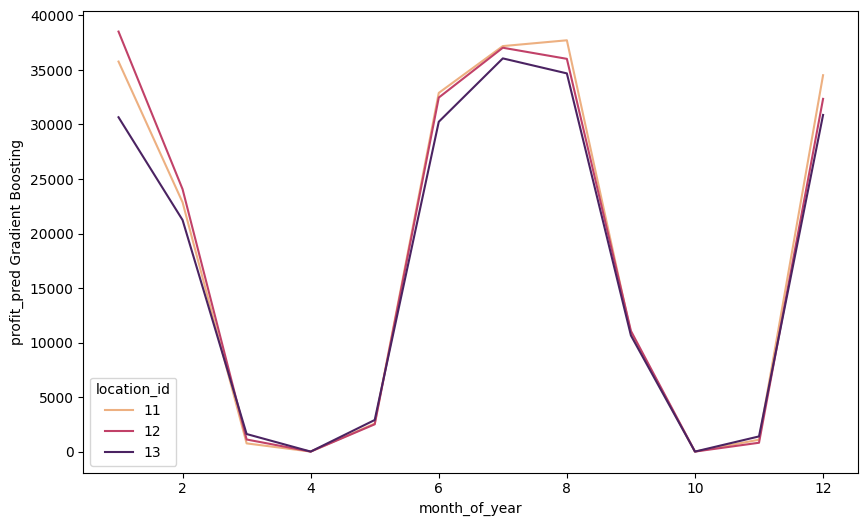

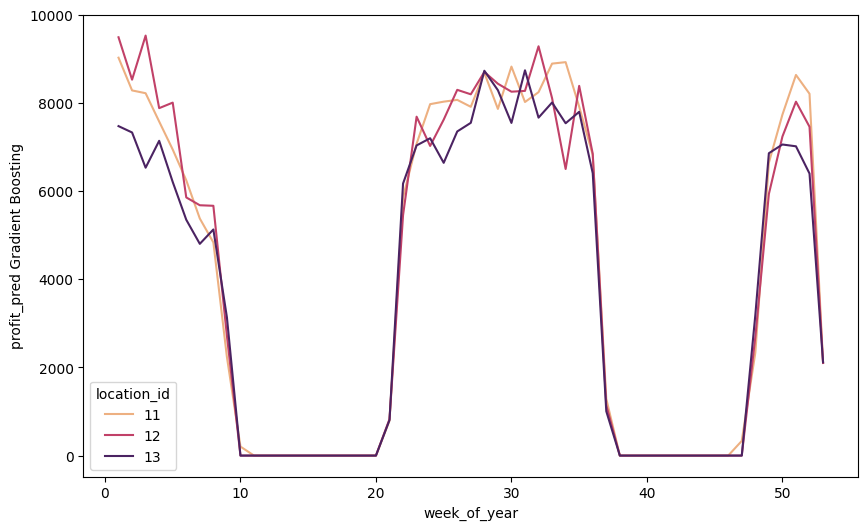

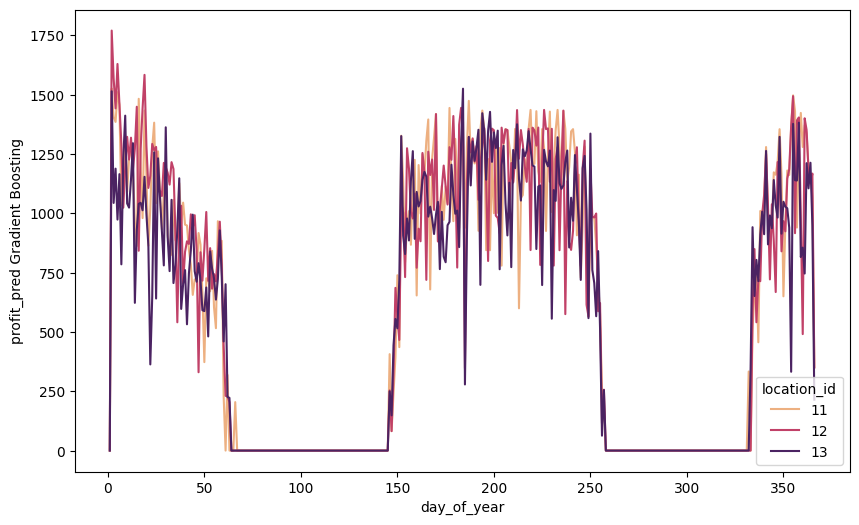

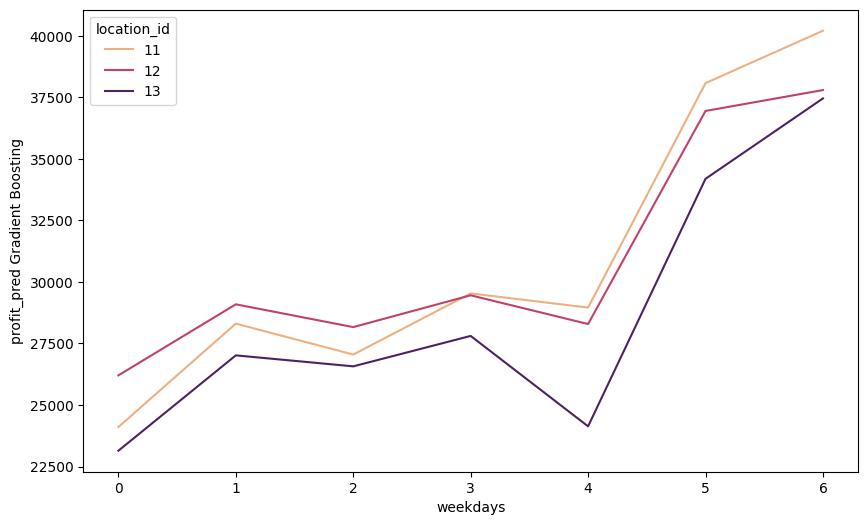

In [43]:
# Plot out the predicted profits to compare with the old location profit data:

plt.figure(figsize = (10,6))
sns.lineplot(data = new_location_data.groupby(['location_id', 'month_of_year'])['profit_pred Gradient Boosting'].sum().reset_index(), x='month_of_year', y='profit_pred Gradient Boosting', hue='location_id', palette = "flare")

plt.figure(figsize = (10,6))
sns.lineplot(data = new_location_data.groupby(['location_id', 'week_of_year'])['profit_pred Gradient Boosting'].sum().reset_index(), x='week_of_year', y='profit_pred Gradient Boosting', hue='location_id', palette = "flare")

plt.figure(figsize = (10,6))
sns.lineplot(data = new_location_data.groupby(['location_id', 'day_of_year'])['profit_pred Gradient Boosting'].sum().reset_index(), x='day_of_year', y='profit_pred Gradient Boosting', hue='location_id', palette = "flare")

plt.figure(figsize = (10,6))
sns.lineplot(data = new_location_data.groupby(['location_id', 'weekdays'])['profit_pred Gradient Boosting'].sum().reset_index(), x='weekdays', y='profit_pred Gradient Boosting', hue='location_id', palette = "flare")
plt.show()

plt.show()

In [44]:
new_location_data.loc[new_location_data.year == 2022, ['location_id', 'profit_pred Gradient Boosting', 'profit_pred Random Forest', 'profit_pred Elastic Net', 'profit_pred Lasso', 'profit_pred Linear Regression']].groupby('location_id').sum()

,profit_pred Gradient Boosting,profit_pred Random Forest,profit_pred Elastic Net,profit_pred Lasso,profit_pred Linear Regression
location_id,,,,,
11,47329.107987,47523.976535,45932.641211,46378.086879,46334.053117
12,49027.203183,48894.903787,47943.264154,48962.121888,48923.912169
13,46508.403115,46880.577507,46678.069435,47014.752926,47036.762534


### Finally I recommend Location 12 which has the largest profits for 2022 from Jan - Oct